<h1>Locating with Healthsites.io Notebook - Nigeria<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-and-match-admin-boundary-data" data-toc-modified-id="Prepare-and-match-admin-boundary-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare and match admin boundary data</a></span><ul class="toc-item"><li><span><a href="#Match-health-list-admin-names-to-shapefile-admin-names" data-toc-modified-id="Match-health-list-admin-names-to-shapefile-admin-names-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Match health list admin names to shapefile admin names</a></span><ul class="toc-item"><li><span><a href="#Match-orgunitlevel4-to-Geob-Adm-3" data-toc-modified-id="Match-orgunitlevel4-to-Geob-Adm-3-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Match orgunitlevel4 to Geob Adm 3</a></span></li><li><span><a href="#Match-orgunitlevel3-to-Geob-Adm-2" data-toc-modified-id="Match-orgunitlevel3-to-Geob-Adm-2-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Match orgunitlevel3 to Geob Adm 2</a></span></li><li><span><a href="#Match-orgunitlevel2-to-Geob-Adm-1" data-toc-modified-id="Match-orgunitlevel2-to-Geob-Adm-1-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Match orgunitlevel2 to Geob Adm 1</a></span></li></ul></li></ul></li></ul></div>

Version: April 25, 2023

This notebook works with health facilities from the HMIS Database and attempts to geolocate them, by joining them to administrative shapefiles, other sources of geo-located health facilities, and running queries with geocoding APIs.

**Data Sources**
- Health facilities (hierarchy list)
- Geoboundaries (Adm1 through 4)
- FEWS Admin-2 boundaries (updated post 2017)
- Health Sites IO
- RHINoVision Master Facility List Decision Support System

# Packages and functions

In [1]:
import os
from datetime import datetime
import geopandas as gpd
import pandas as pd
from geopy.geocoders import Nominatim, Bing, GoogleV3
from shapely.geometry import Point
from tqdm import tqdm
import matplotlib.pyplot as plt
import contextily as ctx
from os.path import join
from dotenv import load_dotenv, find_dotenv

# local imports
import geocoding_utils as gcu
import preprocessing_utils as ppu
import search_utils as ssu

In [2]:
iso3 = "NGA"
diso = "ng"
country = "Nigeria"
input_dir = "/Users/dianaholcomb/Documents/GWU/6501_Capstone/workspace/data"
input_filename = "preprocess_NGA_matches.csv"
output_dir = join(input_dir, "output", iso3)
num_admin_levels = 2
num_org_levels = 5
words_to_remove = [" medical laboratory and ultra-sound scanning center",
                   " health clinic & maternity", " health clinic and maternity", "maternity and child health",
                   "model primary health center", "primary health care centre",
                   " clinic and maternity", " community health center", "comprehensive health centre",
                   " emergency operations center", " federal health centre", "government chest hospital", " health and life",
                   " local government area", " maternal and child", " military cantonement hospital", " pharmacy and stores",
                   "primary health care", " primary health center", " primary health centre", "primary health clinic",
                   "central hospital", " city council", "diagnostic laboratory", " district council", "family support",
                   "general hospital", " healthcare clinic", " health care", " health center", " health centre",
                   "health facility", "health post", " health service", "maternal child", " medical center",
                   " medical centre", " medical complex", " medical dispensary", " medical store", "medicare complex",
                   " medicine store", " municipal council", " patent medicine", " pharmaceuticals ltd", " pharmacy ltd",
                   "primary care", " refugee site", "rural hospital", " rural program",  " specialist hospital",
                   " teaching hospital", " ultrasound scan",
                   " airport", " camp", " center", " centre", " chemist", " clinic", " community", " comprehensive",
                   " dentals", " dispensary", " district", " health", " healthcare", " hospital", " maternity",
                   " medical", " memorial", " missionary", " model", "optometry", " outpost", " patent", "pharmacy",
                   " pharmancy", " pharmarcy", " pharnacy", "phc", " state", " town", " village"]
org_level_front_wtr = ["ab", "ad", "ak", "al", "an", "ba", "be", "bo", "by", "cr", "de", "eb", "ed", "ek",
                       "en", "fc", "go", "im", "jg", "ji", "kd", "ke", "kn", "ko", "kt", "kw", "la", "na",
                       "ni", "og", "on", "os", "oy", "pl", "ri", "so", "ta", "yo", "za"]

In [3]:
master_table = pd.read_csv(os.path.join(input_dir, input_filename), encoding='utf-8')
geob_arr = ppu.get_geoboundares(num_admin_levels, iso3)

In [4]:
len(master_table)

8990

In [5]:
master_table.head(2)

,Unnamed: 0,index,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5,organisationunitid,organisationunitname,organisationunitcode,organisationunitdescription,orgunitlevel4_edit,adm2,orgunitlevel3_edit,adm1,orgunitlevel2_edit
0,0,0,ng Federal Government,ab Abia State,ab Ugwunagbo Local Government Area,ab Obeaja Ward,ab 0susu-Aku Health Post,xBa9XtuqgWT,ab 0susu-Aku Health Post,61977087.0,NaN,obeaja,ugwunagbo,ugwunagbo,abia,abia
1,1,2,ng Federal Government,ab Abia State,ab Ohafia Local Government Area,ab Ebemoha Ward,ab 14 Bdb Medical Centre,BOunNtvsHZm,ab 14 Bdb Medical Centre,42911768.0,NaN,ebemoha,ohafia,ohafia,NaN,NaN


In [6]:
for org_lvl in range(2, num_org_levels+1):
    print(f"Unique Level {org_lvl}: {len(master_table[f'orgunitlevel{org_lvl}'].unique())}")


Unique Level 2: 38
Unique Level 3: 771
Unique Level 4: 8936
Unique Level 5: 8932


# Match to locations from alternative sources based on facility name


## Health Sites IO
Import Health Sites from HealthSites.io  
Health sites come in both a node and a way shapefile. You need to import both to get all the sites.

In QGIS, I created centroids from the ways then merged it with the points.
DLH Note: I didn't have access to this merge, so am using the nodes.shp only, for proof of concept

https://healthsites.io/map?country=Liberia

In [7]:
nodes_io = gpd.read_file(os.path.join(input_dir, "healthsitesio", country, f"{country}-node.shp"))
nodes_io = nodes_io.loc[~nodes_io.name.isna()].copy()
nodes_io['name'] = nodes_io['name'].str.lower()
nodes_io.loc[:, "is_point"] = nodes_io.apply(lambda x: type(x.geometry)==Point, axis=1)

In [8]:
len(nodes_io.loc[~nodes_io.is_point])

0

In [9]:
len(nodes_io.loc[nodes_io.geometry.is_valid])==len(nodes_io)

True

In [10]:
import regex as re
def preprocessSpecialChars(siteName, org_level_front_wtr):
    word = siteName.lower()
    for front_bad_word in org_level_front_wtr:
        word = re.sub(f"^{front_bad_word}\s", "", word)

    special_char_regex = r"[^\w\d\s]"
    regex_name = re.sub(special_char_regex, '', word)
    spaces_stripped = re.sub(r'\s+', ' ', regex_name)

    return spaces_stripped

In [11]:
records = master_table.copy()
records['geocoding_method'] = "None"
records['NAME'] = records[f'orgunitlevel{num_org_levels}'].fillna("")
records['NAME'] = records['NAME'].str.lower()

records['NAME'] = records['NAME'].apply(lambda x: preprocessSpecialChars(x, org_level_front_wtr))
nodes_io = ppu.remove_words_df(nodes_io, 'name', words_to_remove)
records = ppu.remove_words_df(records, 'NAME', words_to_remove)
records['NAME'] = records['NAME'].apply(lambda x: preprocessSpecialChars(x, org_level_front_wtr))

print(records['NAME'])
print(nodes_io['name'])

0             0susuaku
1               14 bdb
2              ikpokwu
3           isalanteke
4                ngozi
             ...      
8981      nestle staff
8982        prime care
8984         olobu ara
8986    central prison
8989             borko
Name: NAME, Length: 8419, dtype: object
1                zuman
2         nasiru dokta
4              suleiko
5       medicine store
6                conic
             ...      
3322           wazobia
3324       shadalafiya
3325            keecee
3326        kabusacare
3327          safeside
Name: name, Length: 1816, dtype: object


In [12]:
print(list(nodes_io['name']))

['zuman', 'nasiru dokta', 'suleiko', 'medicine store', 'conic', 'recall life', 'kelvin', 'royal okhia', 'reliance laboratary', 'pharmacist council, edo', 'osimike', 'okungbowa', 'coka', 'doctors quarters', 'airen', 'flowell', 'abe', 'ayolik', 'golden  berries', 'horatio dential', 'ik', 'itohan', 'korban  & stores', 'life line medicare', 'ladith', 'assurance lab', 'josaf pharm', 'nasi', 'new smile dental', 'royal end', 'society for family', 'spring oak', 'sumel optomentry', 'union diagnostics', 'valif', 'urban', 'calvary', '', 'newgate trust', 'jofeg', 'service pharmacetical', 'toni care', 'ehibass  store', 'julsam', 'carolina specialist', 'chinwendu &', 'alfa', 'health of ihe sick', 'hiltopss', 'kamsiyochukwu', 'lotanna', 'first dental consultants dental', 'neuro spinal', 'ntasi obi ndi no naafufu', 'planet', 'sure mercies eye & services', 'white hall', 'ndiagu amechi uwani', 'chinwe', 'vivafoo shop & dietetic', 'moonlight &', 'hansas', 'first holistic physiotherapy', 'victory', 'jacob

In [13]:
print(list(records['NAME']))

['0susuaku', '14 bdb', 'ikpokwu', 'isalanteke', 'ngozi', 'ngwaiyiekwe', 'ozatta', 'umuagalaba', 'umuajoha', 'umuiku ozar', 'abaki', 'abala nkamiri', 'abam', 'abaukwu', 'abayi amano', 'abayi', 'abayi nchokoro', 'abayi okoroato', 'abia university', 'abia', 'abuma', 'acha', 'achara', 'achichi elu', 'adelabu', 'aduanu', 'africare', 'afugiri', 'agbama ii', 'agbamuzu', 'agboakoli alayi', 'agboji', 'agburuezeukwu', 'agu foundation', 'ahia orie', 'ahiaba', 'ahiaba okpuala', 'ahiaubi', 'aiaoji', 'ajata okwuru', 'akanu', 'akanu okpulor', 'akanu umuorie', 'akanukwu', 'akawa', 'akirika nta', 'akoli', 'akpa mbato', 'akporo achara', 'akpukpa', 'akumimo', 'akwete', 'alaoji', 'alaukwu', 'amaba isuikwuato', 'amaba ugwueke', 'amabaime outreach unit', 'amachara', 'amachi', 'amaegbuato', 'amaeke', 'amaeke ibeku', 'amaekpu', 'amaekpu isiahia', 'amaetiti', 'amafor', 'amaibo', 'amaiyi', 'amakam akwete', 'amakpoke', 'amaku', 'amamba', 'amangelukwu', 'amangwu', 'amankalu alayi', 'amankalu igbere', 'amankita', 

In [15]:
gcu.report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 1,1,0.0%
Location from Health Sites IO and within admin 2,29,0.3%
None,8389,99.6%


In [16]:
len(geob_arr)

2

# Geocoding with APIs

In [50]:
# dotenv_path = find_dotenv()
# load_dotenv(dotenv_path)
bing_key = os.environ.get("bing_key")
google_key = os.environ.get("google_key")

In [18]:
geolocator_osm = Nominatim(user_agent="health-equity")
geolocator_bing = Bing(api_key=bing_key)
geolocator_google = GoogleV3(api_key=google_key)

## Facility name and admin 3 names

In [14]:
for org_lev in range(4, num_org_levels+1):

    for idx, row in records.iterrows():

        # Check if there is another entry with location

        match, score = ssu.match_name(row.NAME, list(nodes_io['name']), 80)
        # match, score = match_name(row.name_concat, list(nodes_io.name_concat), 85)
        #print(f"row: {row.NAME}, match: {match}, score: {score}")

        if score > 0:
            #print(f"row: {row.NAME}, match: {match}, score: {score}")
            matching_row = nodes_io.loc[nodes_io['name']==match].copy()
            res = matching_row.iloc[0]

            adm_idx = num_admin_levels
            for geobIdx in range(len(geob_arr)-1, -1, -1): # reverse loop
                #print(f"geobIdx: {geobIdx}, adm_idx: {adm_idx}")
                if f"adm{adm_idx}" in records.columns and not pd.isna(row[f"adm{adm_idx}"]):
                    geob = geob_arr[geobIdx]
                    #print(f"shapeName to find: {row[f'adm{adm_idx}']}")
                    #print(geob['shapeName'].values)
                    adm = geob.loc[geob['shapeName'].str.lower() == row[f'adm{adm_idx}']].copy()
                    #print(f"adm{adm_idx} {adm['shapeName'].values} contains point? {adm['geometry'].values[0].contains(res['geometry'])}")
                    if adm['geometry'].values[0].contains(res.geometry) == True:
                        print(f"FOUND row: {row.NAME}, match: {match}, score: {score} in Location from Health Sites IO and within admin {adm_idx}")
                        records.loc[idx, "longitude"] = res.geometry.x
                        records.loc[idx, "latitude"] = res.geometry.y
                        records.loc[idx, "geocoding_method"] = f"Location from Health Sites IO and within admin {adm_idx}"
                    else:
                        print(f"did not find row: {row.NAME}, match: {match}, score: {score} in Location from Health Sites IO and within admin {adm_idx}")
                adm_idx -= 1


did not find row: abaki, match: abc, score: 100 in Location from Health Sites IO and within admin 2
did not find row: abam, match: abulam, score: 86 in Location from Health Sites IO and within admin 2
did not find row: abaukwu, match: abc, score: 86 in Location from Health Sites IO and within admin 2
did not find row: abia university, match: baze university, score: 89 in Location from Health Sites IO and within admin 2
did not find row: abuma, match: buma, score: 89 in Location from Health Sites IO and within admin 2
did not find row: adelabu, match: atla, score: 86 in Location from Health Sites IO and within admin 2
did not find row: akawa, match: makawa, score: 91 in Location from Health Sites IO and within admin 2
did not find row: amangwu, match: amanawa, score: 89 in Location from Health Sites IO and within admin 2
did not find row: amannagwu, match: amanawa, score: 89 in Location from Health Sites IO and within admin 2
did not find row: asa, match: sasa, score: 86 in Location fro

Geocode based on facility name (orgunitlevel5) + admin 3 name.  
Check to make sure result falls within admin 3 polygon.

In [19]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
# only include trying to geocode rows that have an admin name that is matched to the Geoboundaries file
records_subset = records_subset.loc[~records_subset[f"adm{num_admin_levels}"].isna()].copy()

In [20]:
len(records_subset)

1167

In [21]:
records_subset.head(2)

,Unnamed: 0,index,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5,organisationunitid,organisationunitname,organisationunitcode,organisationunitdescription,orgunitlevel4_edit,adm2,orgunitlevel3_edit,adm1,orgunitlevel2_edit,geocoding_method,NAME,longitude,latitude
0,0,0,ng Federal Government,ab Abia State,ab Ugwunagbo Local Government Area,ab Obeaja Ward,ab 0susu-Aku Health Post,xBa9XtuqgWT,ab 0susu-Aku Health Post,61977087.0,NaN,obeaja,ugwunagbo,ugwunagbo,abia,abia,None,0susuaku,NaN,NaN
1,1,2,ng Federal Government,ab Abia State,ab Ohafia Local Government Area,ab Ebemoha Ward,ab 14 Bdb Medical Centre,BOunNtvsHZm,ab 14 Bdb Medical Centre,42911768.0,NaN,ebemoha,ohafia,ohafia,NaN,NaN,None,14 bdb,NaN,NaN


In [22]:
smallest_geob = geob_arr[-1]
print(len(smallest_geob))
for adm_idx in range(num_admin_levels-1, -1, -1): # reverse order
    if adm_idx > 0 and f"adm{adm_idx}" in records_subset.columns:
        admNum = adm_idx+1
        print(f"Facility name and admin {admNum} names")
        for idx, row in records_subset.iterrows():
            adm = smallest_geob.loc[smallest_geob['shapeName'].str.lower() == row[f'adm{admNum}']].copy()

            records = gcu.run_geocoding(idx, row, records, adm, ['NAME', f'adm{admNum}'], diso,
                                        geolocator_bing, geolocator_osm, geolocator_google)


        records_subset = records.loc[records.geocoding_method=="None"].copy()
        records_subset = records_subset.loc[~records_subset[f"adm{adm_idx}"].isna()].copy()
        if adm_idx -1 > 0:
            records_subset = records_subset.loc[~records_subset[f"adm{adm_idx-1}"].isna()].copy()
        print(f"Num not found: {len(records_subset)}")

774
Facility name and admin 2 names
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['0susuaku', 'ugwunagbo']
Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['14 bdb', 'ohafia']
Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['ikpokwu', 'ukwa west']
Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['abaki', 'ukwa east']
Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['abala nkamiri', 'obi ngwa']
Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['abam', 'umuahia south']
Didn't find with BING or OSM, no bounding box for Google
Error getting b

In [23]:
gcu.report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 1,1,0.0%
Location from Health Sites IO and within admin 2,29,0.3%
None,8389,99.6%


## Orgunitlevel5 names

Geocode based on orgunitlevel 5 name.  
Check to make sure result falls within admin 3 polygon.  

In [24]:
records['NAME5'] = records['orgunitlevel5'].str.lower()
records = ppu.remove_words_df(records, 'NAME5', words_to_remove)

records_subset = records.loc[records.geocoding_method=="None"].copy()
records_subset = records_subset.loc[~records_subset[f"adm{num_admin_levels}"].isna()].copy()

In [26]:
admNum = num_admin_levels

for org_idx in range(num_org_levels, -1, -1): # reverse order
    if org_idx > 3:
        the_cols = ['NAME5', f'adm{admNum}'] if org_idx == 5 else ['NAME5', f'orgunitlevel{org_idx}']
        print(f"Geocoding for org level {org_idx}")
        orglev_df = records_subset[[f'orgunitlevel{org_idx}', 'NAME5', f'adm{admNum}', 'orgunitlevel1']].drop_duplicates().copy()
        print(f"Num recs at org level {org_idx}: {len(orglev_df)}")

        for idx, row in orglev_df.iterrows():

            adm = smallest_geob.loc[smallest_geob['shapeName'].str.lower() == row[f'adm{admNum}']].copy()
            #print(len(adm))
            orglev_df = gcu.run_geocoding(idx, row, orglev_df, adm, the_cols, diso,
                              geolocator_bing, geolocator_osm, geolocator_google)
        print(orglev_df.geocoding_method.value_counts())

        for idx, row in tqdm(records_subset.iterrows()):
            if org_idx == num_org_levels:
                orglev_geocoded = orglev_df.loc[orglev_df['NAME5']==row['NAME5']].iloc[0]
                records.loc[idx, "longitude"] = orglev_geocoded.longitude
                records.loc[idx, "latitude"] = orglev_geocoded.latitude
                records.loc[idx, "geocoding_method"] = orglev_geocoded.geocoding_method
            else:
                if row.geocoding_method =="None":
                    cent = adm.geometry.representative_point().iloc[0]
                    records.loc[idx, "longitude"] = cent.x
                    records.loc[idx, "latitude"] = cent.y
                    records.loc[idx, "geocoding_method"] = "District centroid"

        records_subset = records.loc[records.geocoding_method=="None"].copy()
        records_subset = records_subset.loc[~records_subset[f"adm{admNum}"].isna()].copy()

Geocoding for org level 5
Num recs at org level 5: 1167
Items: ['ab 0susu-aku', 'ugwunagbo']
Items: ['ab 14 bdb', 'ohafia']
Items: ['ab ab ikpokwu', 'ukwa west']
Items: ['ab abaki', 'ukwa east']
Items: ['ab abala nkamiri', 'obi ngwa']
Items: ['ab abam', 'umuahia south']
Items: ['ab abaukwu', 'aba south']
Items: ['ab abayi', 'isiala-ngwa north']
Items: ['ab abia  university', 'osisioma ngwa']
Items: ['ab abuma', 'arochukwu']
Items: ['ab acha', 'isiukwuato']
Items: ['ab adelabu', 'umuahia north']
Items: ['ab africare', 'isiala-ngwa south']
Items: ['ab agbamuzu', 'bende']
Items: ['ab ahia orie', 'ikwuano']
Items: ['ab akawa', 'umu-nneochi']
Items: ['ab amangwu      post', 'arochukwu']
Items: ['ab amannagwu', 'arochukwu']
Items: ['ab amaobu', 'ikwerre']
Items: ['ab arochukwu', 'arochukwu']
Items: ['ab asa', 'asa']
Items: ['ab asa-okpulor i', 'aba north']
Items: ['ab eluma', 'eleme']
Items: ['ab isu', 'isu']
Items: ['ab obinkita', 'arochukwu']
Items: ['ab obugwu', 'ugwunagbo']
Items: ['abia

1167it [00:00, 1452.63it/s]


Geocoding for org level 4
Num recs at org level 4: 117
Items: ['ab asa', 'ab Asa Ward']
Items: ['ab isu', 'ab Isu Ward']
Items: ['abia omuma', 'im Etiti/Abia Ward']
Items: ['ad 163 nigerian airforce', 'ad Karewa Ward']
Items: ['ad adamawa limited', 'ad Makama B Ward']
Items: ['ad bakka', 'ad Dumne Ward']
Items: ['ad gangtum', 'ad Sugu Ward']
Items: ['ad madagali  (bamako)', 'ad Madagali Ward']
Items: ['ak asiak obufa', 'ak Effiat 1 Ward']
Items: ['ak awa ndem emen', 'ak Odoro Ukwok Ward 9']
Items: ['ak ikot akpa nkuk', 'ak Ukanafun 1 Ward']
Items: ['ak ikot odiong', 'ak Ukanafun 2 Ward']
Items: ['ak ikot okusung', 'ak Ukanafun 4 Ward']
Items: ['ak ikot unah', 'ak Ukanafun 3 Ward']
Items: ['ak utu nsekhe', 'ak Ukanafun 5 Ward']
Items: ['an anaku', 'an Anaku Ward']
Items: ['an oba i', 'an Oba Ward']
Items: ['ba adamoyel', 'ba Gambaki Ward']
Items: ['ba aishin', 'ba Gumai Ward']
Items: ['ba badaromo', 'ba Yali Ward']
Items: ['ba badel', 'ba Bununu West Ward']
Items: ['ba baima', 'ba Baima

117it [00:00, 1504.73it/s]


In [27]:
gcu.report_geocoding(records)

,count,pct
geocoding_method,,
District centroid,117,1.4%
Location from Health Sites IO and within admin 1,1,0.0%
Location from Health Sites IO and within admin 2,29,0.3%
NAME5 and adm2 query Bing,633,7.5%
NAME5 and adm2 query Google,285,3.4%
NAME5 and adm2 query OSM,132,1.6%
None,7221,85.8%


## Admin 3  and admin 2 names

In [35]:
admin_lev = 2
for geob_idx in range(len(geob_arr)-1, -1, -1): # reverse order
    print(f"Admin level {admin_lev}, geob idx: {geob_idx}")
    if f"adm{admin_lev}" in records_subset.columns:
        geob = geob_arr[geob_idx]
        records_subset = records.loc[records.geocoding_method=="None"].copy()
        records_subset = records_subset.loc[~records_subset[f"adm{admin_lev}"].isna()].copy()
        print(f"Num records to find: {len(records_subset)}")

        orglev4_df = records_subset[['orgunitlevel4', f"adm{admin_lev}", 'orgunitlevel1']].drop_duplicates().copy()
        print(f"Len of org level: {len(orglev4_df)}")
        if len(orglev4_df) == 0:
            print(f"We've already found everything with a non-null adm{admin_lev}")

        for idx, row in tqdm(orglev4_df.iterrows()):
            adm2 = geob.loc[geob['shapeName'].str.lower() == row[f"adm{admin_lev}"]].copy()
            orglev4_df = gcu.run_geocoding(idx, row, orglev4_df, adm2, ['orgunitlevel4', f"adm{admin_lev}"], diso,
                                           geolocator_bing, geolocator_osm, geolocator_google)

        for idx, row in tqdm(records_subset.iterrows()):
            orglev4_geocoded = orglev4_df.loc[orglev4_df['orgunitlevel4']==row['orgunitlevel4']].iloc[0]
            records.loc[idx, "longitude"] = orglev4_geocoded.longitude
            records.loc[idx, "latitude"] = orglev4_geocoded.latitude
            records.loc[idx, "geocoding_method"] = orglev4_geocoded.geocoding_method

        admin_lev -= 1

Admin level 2, geob idx: 1
Num records to find: 0
Len of org level: 0
We've already found everything with a non-null adm2


0it [00:00, ?it/s]
0it [00:00, ?it/s]


Admin level 1, geob idx: 0
Num records to find: 0
Len of org level: 0
We've already found everything with a non-null adm1


0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [36]:
gcu.report_geocoding(records)

,count,pct
geocoding_method,,
District centroid,117,1.4%
Location from Health Sites IO and within admin 1,1,0.0%
Location from Health Sites IO and within admin 2,29,0.3%
NAME5 and adm2 query Bing,633,7.5%
NAME5 and adm2 query Google,285,3.4%
NAME5 and adm2 query OSM,132,1.6%
None,7221,85.8%


# Map and save results

In [37]:
results = records.copy()

In [38]:
results.geocoding_method.unique()

array(['NAME5 and adm2 query Bing', 'NAME5 and adm2 query Google', 'None',
       'NAME5 and adm2 query OSM', 'District centroid',
       'Location from Health Sites IO and within admin 2',
       'Location from Health Sites IO and within admin 1'], dtype=object)

In [39]:
# facility name and adm 3
results.loc[results.geocoding_method=="NAME and adm3 query Bing", "geocoding_method"] = "orgunitlevel6 and adm3 query"
results.loc[results.geocoding_method=="NAME and adm3 query OSM", "geocoding_method"] = "orgunitlevel6 and adm3 query"
results.loc[results.geocoding_method=="NAME and adm3 query Google", "geocoding_method"] = "orgunitlevel6 and adm3 query"

# facility name and adm 2
results.loc[results.geocoding_method=="NAME and adm2 query Bing", "geocoding_method"] = "orgunitlevel6 and adm2 query"
results.loc[results.geocoding_method=="NAME and adm2 query OSM", "geocoding_method"] = "orgunitlevel6 and adm2 query"
results.loc[results.geocoding_method=="NAME and adm2 query Google", "geocoding_method"] = "orgunitlevel6 and adm2 query"

# facility name and adm 1
results.loc[results.geocoding_method=="NAME and adm1 query Bing", "geocoding_method"] = "orgunitlevel6 and adm1 query"
results.loc[results.geocoding_method=="NAME and adm1 query OSM", "geocoding_method"] = "orgunitlevel6 and adm1 query"
results.loc[results.geocoding_method=="NAME and adm1 query Google", "geocoding_method"] = "orgunitlevel6 and adm1 query"

# facility name and adm 3
results.loc[results.geocoding_method=="NAME5 and adm3 query Bing", "geocoding_method"] = "orgunitlevel5 and adm3 query"
results.loc[results.geocoding_method=="NAME5 and adm3 query OSM", "geocoding_method"] = "orgunitlevel5 and adm3 query"
results.loc[results.geocoding_method=="NAME5 and adm3 query Google", "geocoding_method"] = "orgunitlevel5 and adm3 query"

# facility name and adm 2
results.loc[results.geocoding_method=="NAME5 and adm2 query Bing", "geocoding_method"] = "orgunitlevel5 and adm2 query"
results.loc[results.geocoding_method=="NAME5 and adm2 query OSM", "geocoding_method"] = "orgunitlevel5 and adm2 query"
results.loc[results.geocoding_method=="NAME5 and adm2 query Google", "geocoding_method"] = "orgunitlevel5 and adm2 query"

# facility name and adm 1
results.loc[results.geocoding_method=="NAME5 and adm1 query Bing", "geocoding_method"] = "orgunitlevel5 and adm1 query"
results.loc[results.geocoding_method=="NAME5 and adm1 query OSM", "geocoding_method"] = "orgunitlevel5 and adm1 query"
results.loc[results.geocoding_method=="NAME5 and adm1 query Google", "geocoding_method"] = "orgunitlevel5 and adm1 query"

# adm 3 name
results.loc[results.geocoding_method=="orgunitlevel4 query Bing", "geocoding_method"] = "orgunitlevel4 query"
results.loc[results.geocoding_method=="orgunitlevel4 query OSM", "geocoding_method"] = "orgunitlevel4 query"
results.loc[results.geocoding_method=="orgunitlevel4 query Google", "geocoding_method"] = "orgunitlevel4 query"

# adm 3 name and adm2
results.loc[results.geocoding_method=="orgunitlevel4 and adm2 query Bing", "geocoding_method"] = "orgunitlevel4 and adm2 query"
results.loc[results.geocoding_method=="orgunitlevel4 and adm2 query OSM", "geocoding_method"] = "orgunitlevel4 and adm2 query"
results.loc[results.geocoding_method=="orgunitlevel4 and adm2 query Google", "geocoding_method"] = "orgunitlevel4 and adm2 query"

# adm 3 name and adm2
results.loc[results.geocoding_method=="orgunitlevel4 and adm1 query Bing", "geocoding_method"] = "orgunitlevel4 and adm1 query"
results.loc[results.geocoding_method=="orgunitlevel4 and adm1 query OSM", "geocoding_method"] = "orgunitlevel4 and adm1 query"
results.loc[results.geocoding_method=="orgunitlevel4 and adm1 query Google", "geocoding_method"] = "orgunitlevel4 and adm1 query"

# Centroid
results.loc[results.geocoding_method=="District centroid", "geocoding_method"] = "Adm3 centroid"

In [40]:
gcu.report_geocoding(results)

,count,pct
geocoding_method,,
Adm3 centroid,117,1.4%
Location from Health Sites IO and within admin 1,1,0.0%
Location from Health Sites IO and within admin 2,29,0.3%
None,7221,85.8%
orgunitlevel5 and adm2 query,1050,12.5%


In [41]:
results.loc[:, "geometry"] = results.apply(lambda x: Point(x.longitude, x.latitude), axis=1)
results = gpd.GeoDataFrame(results, geometry='geometry', crs='EPSG:4326')

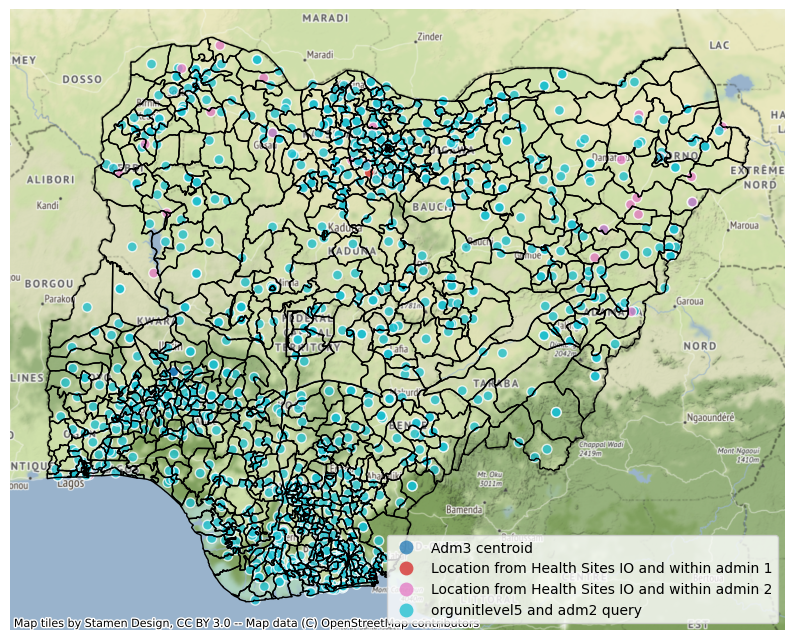

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
smallest_geob.boundary.plot(ax=ax, color='black', linewidth=1).set_axis_off()
results.loc[results.geocoding_method!="None"].plot(ax=ax, column='geocoding_method', edgecolor='white', markersize=50, alpha=0.75, legend=True)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)

## Join attributes from adminsitrative polygons

Join admin data back to results.  
For adm3 features, use spatial join to geob3.  

In [43]:
results2 = results.loc[~(results.longitude.isna())].copy()

In [44]:
records_subset = records.loc[records.geocoding_method=="None"].copy()

In [45]:
len(records_subset)

7221

In [46]:
for gIdx in range(len(geob_arr)-1, -1, -1):
    gNum = gIdx +1
    print(gIdx)

    geob = geob_arr[gIdx]
    results2 = gpd.sjoin(results2, geob[["shapeName", "shapeID", "geometry"]], how='left', predicate='intersects')
    results2.drop('index_right', axis=1, inplace=True)
    results2.rename(
        columns={
            'shapeName': f'geob_adm{gNum}',
            'shapeID': f'geob_adm{gNum}_id',
        }, inplace=True)

1
0


In [47]:
for gIdx in range(len(geob_arr)-1, -1, -1):
    gNum = gIdx +1
    print(results2[f"geob_adm{gNum}"].isna().sum())
    results2.rename(
        columns={
            f'adm{gNum}': f'fuzzy_match_adm{gNum}'
        }, inplace=True)

0
1


In [48]:
results_final = results2.copy()

In [49]:
ts = datetime.now().strftime("%m.%d.%y")
results_final.to_csv(join(output_dir, f"{iso3}_geocoding_{ts}.csv"))
results_final.to_file(join(output_dir, f"{iso3}_geocoding_{ts}.json"), driver="GeoJSON")